In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
China_province_map_ = gpd.read_file(r'../data/China-maps/province.shp')
China_city_map = gpd.read_file(r'../data/China-maps/city.shp')
China_county_map_ = gpd.read_file(r'../data/China-maps/county.shp')
China_nine_lines_map_ = gpd.read_file(r'../data/China-maps/boundary.shp')

China_province_map = China_province_map_.to_crs(2381) 
China_county_map = China_county_map_.to_crs(2381)
China_nine_lines_map = China_nine_lines_map_.to_crs(2381)

In [5]:
prv3al_ = gpd.read_file(r'../data/prv3al/prv3al.shp')
prv3al = prv3al_.to_crs('EPSG:4326')
oilfield_sites_ = pd.read_excel(r'../data/油气藏数据.xlsx')

In [6]:
oilfield_sites = gpd.GeoDataFrame(data=oilfield_sites_, geometry=gpd.points_from_xy(oilfield_sites_['经度'], oilfield_sites_['纬度']), crs='EPSG:4326')
oilfield_sites = oilfield_sites[oilfield_sites['selected'] == 1]
oilfield_sites = oilfield_sites[~oilfield_sites['经度'].isna()]
oilfield_sites['石油地质储量（万t）'] = oilfield_sites['石油地质储量（万t）'].astype(float)
oilfield_sites['OOIP'] = oilfield_sites['石油地质储量（万t）'] / 100   # unit: Mt
oilfield_sites.reset_index(inplace=True, drop=True)
oilfield_sites = oilfield_sites.to_crs(2381)

In [7]:
selected_basin_index = [
    3, 
    4, 
    7, 
    8, 
    10, 
    13, 
    18,
    21, 
    26, 
    35, 
    39, 
    40, 
    43, 
    45, 
    52, # Korea Bay Basin 
    53,
    56, 
    64, # Subei Yellow Sea Basin
    66, # Qiangtang Tanggula Basin 
    68, 
    73, # East China Sea Basin 
    79, # Nanyang Basin 
    81, 
    82, # Cuoqing Lunpola Basin
    84, # Qabdu Basin, 
    85, 
    90, # Lhasa Basin 
    92, 
    93, 
    94, 
    97, 
    99, 
    100, # Taixinan Basin
    101, 
    103, # Pearl River Mouth Basin
    107, 
    108, 
    112, 
]

In [8]:
China_basins_ = prv3al.loc[selected_basin_index]
China_basins = China_basins_.to_crs(2381)

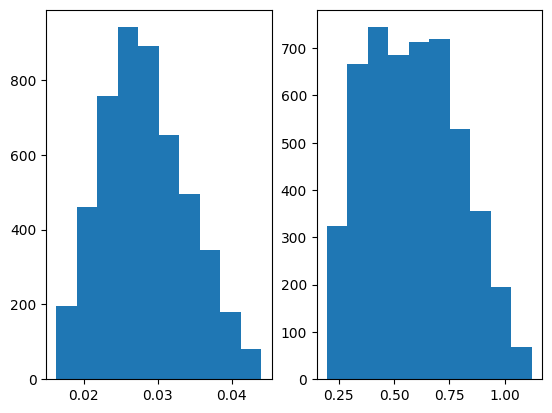

In [9]:
np.random.seed(100)
n = 5000
q = np.random.uniform(0.015, 0.025, n)
h = np.random.uniform(150, 250, n)
gg = q * h * 0.2 * 0.71 * 0.05

B_0 = np.random.uniform(1.2, 2.0, n)
EXTRA = np.random.uniform(0.053, 0.183, n)
R_CO2 = np.random.uniform(2.113, 3.522)
hh = (B_0 / 0.81) * 0.75 * EXTRA * R_CO2

plt.subplot(121), plt.hist(gg)
plt.subplot(122), plt.hist(hh)
plt.show()

In [10]:
intersection = gpd.overlay(China_county_map, China_basins, how='intersection')
intersection = intersection.to_crs('ESRI:54009')
intersection['intersect_area_sqm'] = intersection.geometry.area
intersection['intersect_area'] = intersection['intersect_area_sqm'] / 1e6

In [11]:
oilfields_within_counties = gpd.sjoin(oilfield_sites, China_county_map, how='left', predicate='within')
unassigned_oilfields = oilfields_within_counties[oilfields_within_counties['index_right'].isna()]
total_ooip_per_county = oilfields_within_counties.dropna(subset=['index_right']).groupby(['省', '市', '县', '县代码'])['OOIP'].sum().reset_index()

In [12]:
for a_code in intersection['县代码'].unique():
    a_area = intersection[intersection['县代码'] == a_code]['intersect_area'].sum()
    the_index = China_county_map[China_county_map['县代码'] == a_code].index[0]
    China_county_map.loc[the_index, 'basin_area'] = a_area
    aa, bb, cc = np.percentile(gg, [2.5, 50, 97.5])
    China_county_map.loc[the_index, 'G_DSA'] = a_area * bb
    China_county_map.loc[the_index, 'G_DSA_low'] = a_area * aa
    China_county_map.loc[the_index, 'G_DSA_high'] = a_area * cc

In [13]:
for a_code in total_ooip_per_county['县代码'].unique():
    the_index = China_county_map[China_county_map['县代码'] == a_code].index[0]
    the_OOIP = total_ooip_per_county[total_ooip_per_county['县代码'] == a_code]['OOIP'].sum()
    China_county_map.loc[the_index, 'OOIP'] = the_OOIP
    aa, bb, cc = np.percentile(hh, [2.5, 50, 97.5])
    China_county_map.loc[the_index, 'G_EOR'] = the_OOIP * bb
    China_county_map.loc[the_index, 'G_EOR_low'] = the_OOIP * aa
    China_county_map.loc[the_index, 'G_EOR_high'] = the_OOIP * cc

In [14]:
China_county_map['G_DSA'] = China_county_map['G_DSA'].fillna(0)
China_county_map['G_EOR'] = China_county_map['G_EOR'].fillna(0)
China_county_map['G_DSA_low'] = China_county_map['G_DSA_low'].fillna(0)
China_county_map['G_EOR_low'] = China_county_map['G_EOR_low'].fillna(0)
China_county_map['G_DSA_high'] = China_county_map['G_DSA_high'].fillna(0)
China_county_map['G_EOR_high'] = China_county_map['G_EOR_high'].fillna(0)

In [16]:
China_county_map[['省', '市', '县', '县代码', 'basin_area', 'OOIP', 'G_DSA', 'G_EOR', 'G_DSA_low', 'G_DSA_high', 'G_EOR_low', 'G_EOR_high']].to_csv(r'../outputs/China_county_carbon_storage.csv', index=False, encoding='utf-8-sig')